In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.6 MB/s eta 0:00:00


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_excel('/content/amazon.xlsx')
df.head(5)

,reviewText,Good product,Poor product,High-quality materials,Low-quality materials,Worth the price,Overpriced,Attractive appearance,Unattractive appearance,Correct size/fit,Too small,Too large
0,Great product and price!,1,0,0,0,1,0,0,0,0,0,0
1,Waaay too small. Will use for futur children!,0,1,0,1,0,0,0,0,0,1,0
2,Stays vibrant after many washes,1,0,1,0,0,0,0,0,0,0,0
3,My son really likes the pink. Ones which I was...,1,0,0,0,0,0,1,0,0,0,0
4,Waaay too small. Will use for future child.,0,1,0,1,0,0,0,0,0,1,0


In [ ]:
column_lst = df.columns.to_list()
column_lst.remove("reviewText")
for column in column_lst:
  print(column, df[column].sum())

Good product 547
Poor product 382
High-quality materials 126
Low-quality materials 103
Worth the price 104
Overpriced 100
Attractive appearance 173
Unattractive appearance 115
Correct size/fit 251
Too small 121
Too large 116


In [ ]:
df_correct_size = [i for i in range(df.shape[0]) if df['Correct size/fit'][i]==1]
df_will_be_delete = np.random.choice(df_correct_size, 150)
df_will_be_delete.shape

df_downsampling = df.drop(index=df_will_be_delete)

df_downsampling.head()

,reviewText,Good product,Poor product,High-quality materials,Low-quality materials,Worth the price,Overpriced,Attractive appearance,Unattractive appearance,Correct size/fit,Too small,Too large
0,Great product and price!,1,0,0,0,1,0,0,0,0,0,0
1,Waaay too small. Will use for futur children!,0,1,0,1,0,0,0,0,0,1,0
2,Stays vibrant after many washes,1,0,1,0,0,0,0,0,0,0,0
3,My son really likes the pink. Ones which I was...,1,0,0,0,0,0,1,0,0,0,0
4,Waaay too small. Will use for future child.,0,1,0,1,0,0,0,0,0,1,0


In [ ]:
column_lst = df_downsampling.columns.to_list()
column_lst.remove("reviewText")
for column in column_lst:
  print(column, df_downsampling[column].sum())

Good product 477
Poor product 333
High-quality materials 109
Low-quality materials 72
Worth the price 89
Overpriced 63
Attractive appearance 138
Unattractive appearance 103
Correct size/fit 141
Too small 111
Too large 113


QUÁ KHÓ ĐỂ DOWNSAMPLING => DÙNG DATA GỐC

In [ ]:
data = df.to_numpy()
x = data[:,0]
y = data[:,1:]
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (834,)
y shape: (834, 11)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)

print("Train Set")
print(x_train.shape, y_train.shape)
print("Test Set")
print(x_test.shape, y_test.shape)

Train Set
(667,) (667, 11)
Test Set
(167,) (167, 11)


In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].


In [ ]:
#Neural network
dropout = tf.keras.layers.Dropout(0.1, name="dropout")(pooled_output)
output_layer = tf.keras.layers.Dense(11, activation='sigmoid', name="output")(dropout)

#Constructing model
model = tf.keras.Model(inputs=[text_input],outputs=[output_layer])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall")
]
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=METRICS)

In [ ]:
y_train = np.array(y_train, dtype='int32')
y_test = np.array(y_test, dtype='int32')

y_train = tf.cast(y_train, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)
model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_test, y_test)
)

Epoch 1/20
21/21 [==============================] - 16s 208ms/step - loss: 0.5141 - accuracy: 0.7679 - precision: 0.4886 - recall: 0.3455 - val_loss: 0.5012 - val_accuracy: 0.7817 - val_precision: 0.6667 - val_recall: 0.2641
Epoch 2/20
21/21 [==============================] - 3s 159ms/step - loss: 0.4496 - accuracy: 0.8131 - precision: 0.6943 - recall: 0.3252 - val_loss: 0.4530 - val_accuracy: 0.7980 - val_precision: 0.7040 - val_recall: 0.3398
Epoch 3/20
21/21 [==============================] - 3s 158ms/step - loss: 0.4180 - accuracy: 0.8230 - precision: 0.7257 - recall: 0.3616 - val_loss: 0.4285 - val_accuracy: 0.8144 - val_precision: 0.7763 - val_recall: 0.3680
Epoch 4/20
21/21 [==============================] - 3s 159ms/step - loss: 0.3972 - accuracy: 0.8296 - precision: 0.7566 - recall: 0.3747 - val_loss: 0.4128 - val_accuracy: 0.8242 - val_precision: 0.8233 - val_recall: 0.3831
Epoch 5/20
21/21 [==============================] - 3s 166ms/step - loss: 0.3804 - accuracy: 0.8362 - p

In [ ]:
#Fine tuning
learning_rate = 2e-5

In [ ]:
encoder.trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss="binary_crossentropy",
              metrics=METRICS)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_test, y_test)
)

Epoch 1/20
21/21 [==============================] - 45s 393ms/step - loss: 0.2799 - accuracy: 0.8794 - precision: 0.8282 - recall: 0.6090 - val_loss: 0.2528 - val_accuracy: 0.8938 - val_precision: 0.8739 - val_recall: 0.6753
Epoch 2/20
21/21 [==============================] - 7s 345ms/step - loss: 0.1974 - accuracy: 0.9244 - precision: 0.8928 - recall: 0.7601 - val_loss: 0.2176 - val_accuracy: 0.9145 - val_precision: 0.8900 - val_recall: 0.7532
Epoch 3/20
21/21 [==============================] - 7s 349ms/step - loss: 0.1528 - accuracy: 0.9462 - precision: 0.9307 - recall: 0.8258 - val_loss: 0.1976 - val_accuracy: 0.9211 - val_precision: 0.8933 - val_recall: 0.7792
Epoch 4/20
21/21 [==============================] - 7s 345ms/step - loss: 0.1186 - accuracy: 0.9648 - precision: 0.9592 - recall: 0.8837 - val_loss: 0.1832 - val_accuracy: 0.9271 - val_precision: 0.8905 - val_recall: 0.8095
Epoch 5/20
21/21 [==============================] - 7s 344ms/step - loss: 0.0966 - accuracy: 0.9691 - p

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, accuracy_score


Text(0.5, 1.0, 'Training and Validation Accuracy')

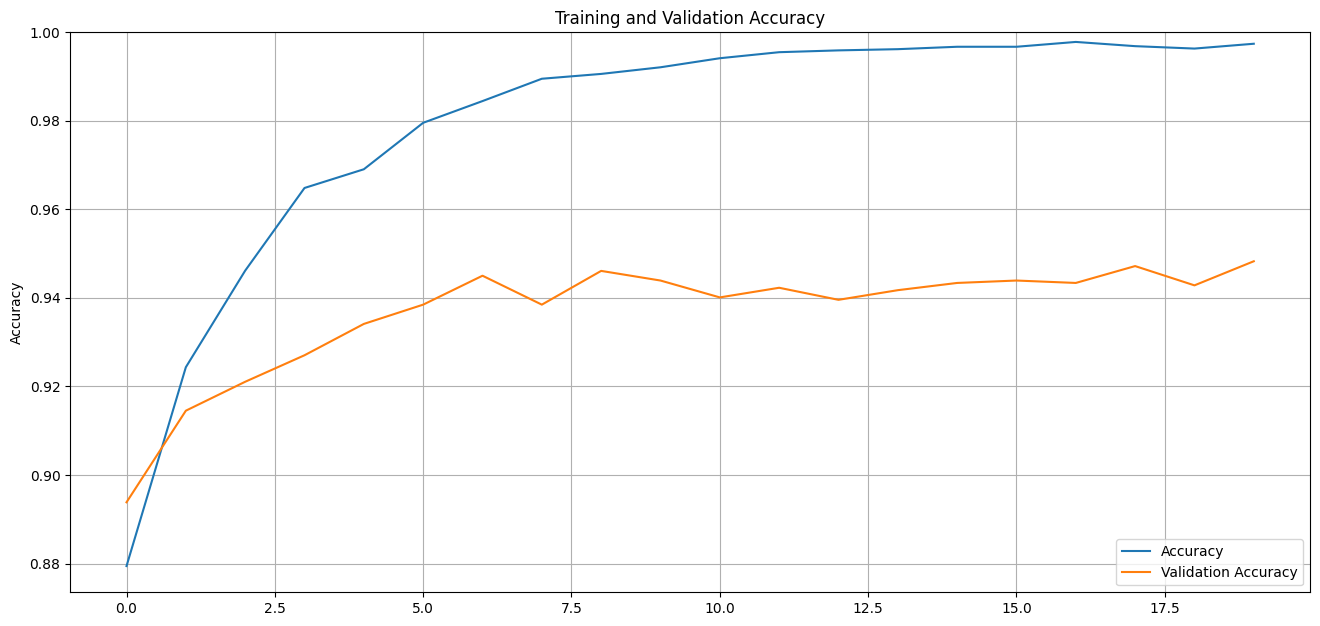

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.grid(visible=True)
plt.title('Training and Validation Accuracy')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']


(0.0, 0.29314331696368756)

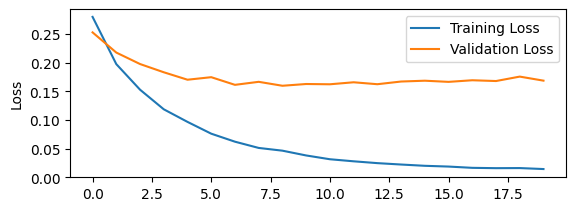

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, max(plt.ylim())])

In [ ]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
unlabel_data = pd.read_excel('/content/unlabel_amazon_shortened.xlsx')
unlabel_data.head(5)

,reviewText
0,"This book has beautiful photos, good and under..."
1,Loved their approach in this book and that it ...
2,great
3,"Always love the way Eva thinks, and there are ..."
4,Nice patterns


In [ ]:
#split into 5 part

df1 = pd.DataFrame(unlabel_data["reviewText"][:2000])
df2 = pd.DataFrame(unlabel_data["reviewText"][2000:4000])
df3 = pd.DataFrame(unlabel_data["reviewText"][4000:6000])
df4 = pd.DataFrame(unlabel_data["reviewText"][6000:8000])
df5 = pd.DataFrame(unlabel_data["reviewText"][8000:])

In [ ]:
df1.head()

,reviewText
0,"This book has beautiful photos, good and under..."
1,Loved their approach in this book and that it ...
2,great
3,"Always love the way Eva thinks, and there are ..."
4,Nice patterns


In [ ]:
print(unlabel_data['reviewText'].shape)

(10000,)


In [ ]:
input = df1.to_numpy()


In [ ]:
predictions = model.predict(input.tolist())

63/63 [==============================] - 8s 123ms/step


In [ ]:
predictions[]

array([[9.9996698e-01, 6.6097004e-05, 8.3877701e-01, ..., 1.8697764e-01,
        9.0866779e-06, 2.9112765e-04],
       [9.9992681e-01, 5.9477211e-04, 8.7285481e-02, ..., 1.0061720e-01,
        6.4493790e-05, 4.2389263e-05],
       [9.9512535e-01, 5.9083320e-04, 2.0424663e-03, ..., 1.4299272e-03,
        1.2084829e-03, 3.1179506e-03],
       ...,
       [9.9947232e-01, 1.4966834e-04, 2.9834817e-04, ..., 8.9197056e-03,
        1.1798864e-03, 2.4237146e-03],
       [9.9997807e-01, 4.5395791e-05, 1.7130850e-03, ..., 2.4876915e-01,
        7.3623909e-05, 3.4032288e-04],
       [9.9954540e-01, 6.6977721e-03, 1.4712535e-02, ..., 9.9630666e-01,
        2.7856113e-06, 3.3722739e-04]], dtype=float32)

In [ ]:
assigned_labels = predictions[0] > 0.5
assigned_labels

array([ True, False,  True, False,  True, False, False, False, False,
       False, False])

In [ ]:
confident_scores = []
for i in range(len(predictions)):
  assigned_labels = predictions[i] > 0.5
  overall_confidence = np.mean(predictions[i][assigned_labels])
  confident_scores.append(overall_confidence)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
auto_dataset.columns[1:]

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='object')

In [ ]:
confident_scores = np.array(confident_scores)
high_confident = np.where(confident_scores>=0.8)
low_confident = np.where(confident_scores<0.8)

autolabel_dataset = df1["reviewText"].iloc[high_confident[0]]

autolabels = pd.DataFrame(predictions[high_confident]>0.5)
auto_dataset = pd.concat([autolabel_dataset,autolabels],axis=1)
auto_dataset = auto_dataset.dropna()

columns_to_convert = auto_dataset.columns[1:]
for col in columns_to_convert:
    auto_dataset[col] = auto_dataset[col].astype(int)
auto_dataset.head(5)




,reviewText,0,1,2,3,4,5,6,7,8,9,10
0,"This book has beautiful photos, good and under...",1,0,1,0,1,0,0,0,0,0,0
1,Loved their approach in this book and that it ...,1,0,0,0,0,0,0,0,0,0,0
2,great,1,0,0,0,0,0,0,0,0,0,0
3,"Always love the way Eva thinks, and there are ...",1,0,0,0,0,0,1,0,0,0,0
4,Nice patterns,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = pd.read_excel('/content/amazon.xlsx')
new_column_names = list(range(11))
new_column_names.insert(0,"reviewText")
df.columns = new_column_names

df.head(5)

,reviewText,0,1,2,3,4,5,6,7,8,9,10
0,Great product and price!,1,0,0,0,1,0,0,0,0,0,0
1,Waaay too small. Will use for futur children!,0,1,0,1,0,0,0,0,0,1,0
2,Stays vibrant after many washes,1,0,1,0,0,0,0,0,0,0,0
3,My son really likes the pink. Ones which I was...,1,0,0,0,0,0,1,0,0,0,0
4,Waaay too small. Will use for future child.,0,1,0,1,0,0,0,0,0,1,0


In [ ]:
df = pd.concat([df, auto_dataset],axis=0)

In [ ]:
df.head()

,reviewText,0,1,2,3,4,5,6,7,8,9,10
0,Great product and price!,1,0,0,0,1,0,0,0,0,0,0
1,Waaay too small. Will use for futur children!,0,1,0,1,0,0,0,0,0,1,0
2,Stays vibrant after many washes,1,0,1,0,0,0,0,0,0,0,0
3,My son really likes the pink. Ones which I was...,1,0,0,0,0,0,1,0,0,0,0
4,Waaay too small. Will use for future child.,0,1,0,1,0,0,0,0,0,1,0


In [ ]:
manuallabel_dataset = df1["reviewText"].iloc[low_confident]
manuallabel_dataset.to_excel("manually_label.xlsx")

In [ ]:
#After label
labeled_dataset = pd.read_excel('/content/manually_label.xlsx')
df = pd.concat(df, labeled_dataset)

In [ ]:
def fitting_model(df):
  data = df.to_numpy()
  x = data[:,0]
  y = data[:,1:]
  x_train, x_test, y_train, y_test = train_test_split(
      x,
      y,
      test_size=0.2,
      shuffle=True,
      random_state=42,
  )
  y_train = np.array(y_train, dtype='int32')
  y_test = np.array(y_test, dtype='int32')

  y_train = tf.cast(y_train, dtype=tf.float32)
  y_test = tf.cast(y_test, dtype=tf.float32)

  encoder.trainable = False
  model.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics=METRICS)
  model.fit(
      x_train,
      y_train,
      epochs=10,
      validation_data=(x_test, y_test)
  )

  encoder.trainable = True

  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss="binary_crossentropy",
                metrics=METRICS)
  history = model.fit(
      x_train,
      y_train,
      epochs=10,
      validation_data=(x_test, y_test)
  )

In [ ]:
def auto_label_data(dataframe1):
  data = dataframe1.to_numpy()
  input = data[:,0]
  predictions = model.predict(input.tolist())
  confident_scores = []
  for i in range(len(predictions)):
    assigned_labels = predictions[i] > 0.5
    overall_confidence = np.mean(predictions[i][assigned_labels])
    confident_scores.append(overall_confidence)

  confident_scores = np.array(confident_scores)
  high_confident = np.where(confident_scores>=0.8)
  low_confident = np.where(confident_scores<0.8)

  autolabel_dataset = dataframe1["reviewText"].iloc[high_confident[0]]

  autolabels = pd.DataFrame(predictions[high_confident]>0.5)
  auto_dataset = pd.concat([autolabel_dataset,autolabels],axis=1)
  auto_dataset = auto_dataset.dropna()

  columns_to_convert = auto_dataset.columns[1:]
  for col in columns_to_convert:
      auto_dataset[col] = auto_dataset[col].astype(int)

  df = pd.concat([df, auto_dataset],axis=0)
  # manuallabel_dataset = dataframe1["reviewText"][low_confident]
  # manuallabel_dataset.to_excel("manually_label.xlsx")

In [ ]:
#After label
labeled_dataset = pd.read_excel('/content/manually_label.xlsx')
df = pd.concat(df, labeled_dataset)

In [ ]:
fitting_model(df)
auto_label_data(df2)
#After label
# labeled_dataset = pd.read_excel('/content/manually_label.xlsx')
# df = pd.concat(df, labeled_dataset)

Epoch 1/20
53/53 [==============================] - 12s 176ms/step - loss: 0.4091 - accuracy: 0.8974 - precision: 0.7549 - recall: 0.7163 - val_loss: 0.3402 - val_accuracy: 0.8906 - val_precision: 0.7414 - val_recall: 0.6943
Epoch 2/20
53/53 [==============================] - 8s 159ms/step - loss: 0.2906 - accuracy: 0.8967 - precision: 0.7548 - recall: 0.6904 - val_loss: 0.2837 - val_accuracy: 0.8936 - val_precision: 0.7804 - val_recall: 0.6502
Epoch 3/20
53/53 [==============================] - 8s 158ms/step - loss: 0.2572 - accuracy: 0.9014 - precision: 0.7808 - recall: 0.6820 - val_loss: 0.2714 - val_accuracy: 0.8983 - val_precision: 0.7923 - val_recall: 0.6652
Epoch 4/20
53/53 [==============================] - 8s 159ms/step - loss: 0.2494 - accuracy: 0.9044 - precision: 0.7945 - recall: 0.6823 - val_loss: 0.2684 - val_accuracy: 0.9020 - val_precision: 0.8116 - val_recall: 0.6631
Epoch 5/20
53/53 [==============================] - 8s 159ms/step - loss: 0.2447 - accuracy: 0.9058 - p

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


UnboundLocalError: ignored

In [ ]:
data = df2.to_numpy()
input = data[:,0]
predictions = model.predict(input.tolist())
confident_scores = []
for i in range(len(predictions)):
  assigned_labels = predictions[i] > 0.5
  overall_confidence = np.mean(predictions[i][assigned_labels])
  confident_scores.append(overall_confidence)

confident_scores = np.array(confident_scores)
high_confident = np.where(confident_scores>=0.8)
low_confident = np.where(confident_scores<0.8)

autolabel_dataset = df2["reviewText"].iloc[high_confident[0]]

autolabels = pd.DataFrame(predictions[high_confident]>0.5)
auto_dataset = pd.concat([autolabel_dataset,autolabels],axis=1)
auto_dataset = auto_dataset.dropna()

columns_to_convert = auto_dataset.columns[1:]
for col in columns_to_convert:
    auto_dataset[col] = auto_dataset[col].astype(int)

df = pd.concat([df, auto_dataset],axis=0)

63/63 [==============================] - 8s 122ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
len(df["reviewText"])

2113

In [ ]:
fitting_model(df)
# auto_label_data(df3)
#After label
# labeled_dataset = pd.read_excel('/content/manually_label.xlsx')
# df = pd.concat(df, labeled_dataset)

Epoch 1/20
53/53 [==============================] - 12s 177ms/step - loss: 0.0084 - accuracy: 0.9767 - precision: 0.9471 - recall: 0.9326 - val_loss: 0.5357 - val_accuracy: 0.8990 - val_precision: 0.7768 - val_recall: 0.6932
Epoch 2/20
53/53 [==============================] - 8s 160ms/step - loss: 0.0068 - accuracy: 0.9973 - precision: 0.9942 - recall: 0.9919 - val_loss: 0.5466 - val_accuracy: 0.8975 - val_precision: 0.7703 - val_recall: 0.6932
Epoch 3/20
53/53 [==============================] - 8s 160ms/step - loss: 0.0071 - accuracy: 0.9966 - precision: 0.9930 - recall: 0.9892 - val_loss: 0.5686 - val_accuracy: 0.8986 - val_precision: 0.7711 - val_recall: 0.6997
Epoch 4/20
53/53 [==============================] - 8s 159ms/step - loss: 0.0065 - accuracy: 0.9966 - precision: 0.9919 - recall: 0.9903 - val_loss: 0.5831 - val_accuracy: 0.8986 - val_precision: 0.7723 - val_recall: 0.6975
Epoch 5/20
53/53 [==============================] - 9s 162ms/step - loss: 0.0067 - accuracy: 0.9964 - p

In [ ]:
data = df3.to_numpy()
input = data[:,0]
predictions = model.predict(input.tolist())
confident_scores = []
for i in range(len(predictions)):
  assigned_labels = predictions[i] > 0.5
  overall_confidence = np.mean(predictions[i][assigned_labels])
  confident_scores.append(overall_confidence)

confident_scores = np.array(confident_scores)
high_confident = np.where(confident_scores>=0.8)
low_confident = np.where(confident_scores<0.8)

autolabel_dataset = df3["reviewText"].iloc[high_confident[0]]

autolabels = pd.DataFrame(predictions[high_confident]>0.5)
auto_dataset = pd.concat([autolabel_dataset,autolabels],axis=1)
auto_dataset = auto_dataset.dropna()

columns_to_convert = auto_dataset.columns[1:]
for col in columns_to_convert:
    auto_dataset[col] = auto_dataset[col].astype(int)

df = pd.concat([df, auto_dataset],axis=0)

63/63 [==============================] - 8s 121ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
fitting_model(df)
# auto_label_data(df4)
#After label
# labeled_dataset = pd.read_excel('/content/manually_label.xlsx')
# df = pd.concat(df, labeled_dataset)

Epoch 1/20
53/53 [==============================] - 13s 176ms/step - loss: 0.0070 - accuracy: 0.9761 - precision: 0.9467 - recall: 0.9298 - val_loss: 0.7660 - val_accuracy: 0.8962 - val_precision: 0.7661 - val_recall: 0.6911
Epoch 2/20
53/53 [==============================] - 8s 159ms/step - loss: 0.0054 - accuracy: 0.9969 - precision: 0.9919 - recall: 0.9919 - val_loss: 0.7693 - val_accuracy: 0.8940 - val_precision: 0.7589 - val_recall: 0.6878
Epoch 3/20
53/53 [==============================] - 8s 159ms/step - loss: 0.0057 - accuracy: 0.9973 - precision: 0.9930 - recall: 0.9928 - val_loss: 0.7790 - val_accuracy: 0.8968 - val_precision: 0.7663 - val_recall: 0.6954
Epoch 4/20
53/53 [==============================] - 8s 159ms/step - loss: 0.0055 - accuracy: 0.9969 - precision: 0.9936 - recall: 0.9903 - val_loss: 0.7812 - val_accuracy: 0.8962 - val_precision: 0.7661 - val_recall: 0.6911
Epoch 5/20
53/53 [==============================] - 8s 159ms/step - loss: 0.0058 - accuracy: 0.9970 - p

In [ ]:
data = df4.to_numpy()
input = data[:,0]
predictions = model.predict(input.tolist())
confident_scores = []
for i in range(len(predictions)):
  assigned_labels = predictions[i] > 0.5
  overall_confidence = np.mean(predictions[i][assigned_labels])
  confident_scores.append(overall_confidence)

confident_scores = np.array(confident_scores)
high_confident = np.where(confident_scores>=0.8)
low_confident = np.where(confident_scores<0.8)

autolabel_dataset = df4["reviewText"].iloc[high_confident[0]]

autolabels = pd.DataFrame(predictions[high_confident]>0.5)
auto_dataset = pd.concat([autolabel_dataset,autolabels],axis=1)
auto_dataset = auto_dataset.dropna()

columns_to_convert = auto_dataset.columns[1:]
for col in columns_to_convert:
    auto_dataset[col] = auto_dataset[col].astype(int)

df = pd.concat([df, auto_dataset],axis=0)

63/63 [==============================] - 8s 122ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
fitting_model(df)
# auto_label_data(df5)
#After label
# labeled_dataset = pd.read_excel('/content/manually_label.xlsx')
# df = pd.concat(df, labeled_dataset)

In [ ]:
data = df5.to_numpy()
input = data[:,0]
predictions = model.predict(input.tolist())
confident_scores = []
for i in range(len(predictions)):
  assigned_labels = predictions[i] > 0.5
  overall_confidence = np.mean(predictions[i][assigned_labels])
  confident_scores.append(overall_confidence)

confident_scores = np.array(confident_scores)
high_confident = np.where(confident_scores>=0.8)
low_confident = np.where(confident_scores<0.8)

autolabel_dataset = df5["reviewText"].iloc[high_confident[0]]

autolabels = pd.DataFrame(predictions[high_confident]>0.5)
auto_dataset = pd.concat([autolabel_dataset,autolabels],axis=1)
auto_dataset = auto_dataset.dropna()

columns_to_convert = auto_dataset.columns[1:]
for col in columns_to_convert:
    auto_dataset[col] = auto_dataset[col].astype(int)

df = pd.concat([df, auto_dataset],axis=0)

63/63 [==============================] - 8s 123ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
len(df["reviewText"])

2113

In [ ]:
#LSTM
#Import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow import string
#Create 3 set data: train, val, and test
data = df.to_numpy()
x = data[:,0]
y = data[:,1:]
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)
y_train = np.array(y_train, dtype='int32')
y_test = np.array(y_test, dtype='int32')

y_train = tf.cast(y_train, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)
word_set = set()
for text in x_train:
  words = text.split()
  for word in words:
    if word not in word_set:
      word_set.add(word)

VOCAB_SIZE = len(word_set)
from tensorflow.keras.layers import TextVectorization

VOCAB_SIZE = 20000
MAX_LENGTH = 50

tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=None,
    output_mode="int",
    output_sequence_length=MAX_LENGTH
)
# fit trên x_train
tokenizer.adapt(x_train)
VOCAB_SIZE = tokenizer.vocabulary_size() # 10654

embedding_layer = Embedding(
    VOCAB_SIZE,
    40,
    embeddings_initializer='uniform', # đưa biến embeddings vào làm weight của layer
    name="embedding" # đặt tên cho layer
)

#Create model
lstm = Sequential()
lstm.add(Input(shape=(1,), dtype=string))
# tokenizer
lstm.add(tokenizer)
# embedding
lstm.add(embedding_layer)
# RNN & MLP
lstm.add(Bidirectional(LSTM(64,
                                  dropout=0.2,
                                  recurrent_dropout=0.2,
                                  return_sequences=True)))
lstm.add(Bidirectional(LSTM(128,
                             dropout=0.2,
                             recurrent_dropout=0.2)))

lstm.add(Dense(11, activation="sigmoid"))

# train
lstm.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=METRICS),
history = lstm.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=20
)

Epoch 1/20
53/53 [==============================] - 69s 1s/step - loss: 0.4283 - accuracy: 0.8400 - precision: 0.6484 - recall: 0.3899 - val_loss: 0.3964 - val_accuracy: 0.8388 - val_precision: 0.7116 - val_recall: 0.3240
Epoch 2/20
53/53 [==============================] - 54s 1s/step - loss: 0.3823 - accuracy: 0.8456 - precision: 0.7150 - recall: 0.3360 - val_loss: 0.4014 - val_accuracy: 0.8388 - val_precision: 0.7116 - val_recall: 0.3240
Epoch 3/20
53/53 [==============================] - 54s 1s/step - loss: 0.3705 - accuracy: 0.8533 - precision: 0.7266 - recall: 0.3877 - val_loss: 0.3792 - val_accuracy: 0.8491 - val_precision: 0.7360 - val_recall: 0.3811
Epoch 4/20
53/53 [==============================] - 54s 1s/step - loss: 0.3292 - accuracy: 0.8737 - precision: 0.8253 - recall: 0.4411 - val_loss: 0.3715 - val_accuracy: 0.8521 - val_precision: 0.7537 - val_recall: 0.3854
Epoch 5/20
53/53 [==============================] - 54s 1s/step - loss: 0.2929 - accuracy: 0.8863 - precision: 0

Text(0.5, 1.0, 'Training and Validation Accuracy')

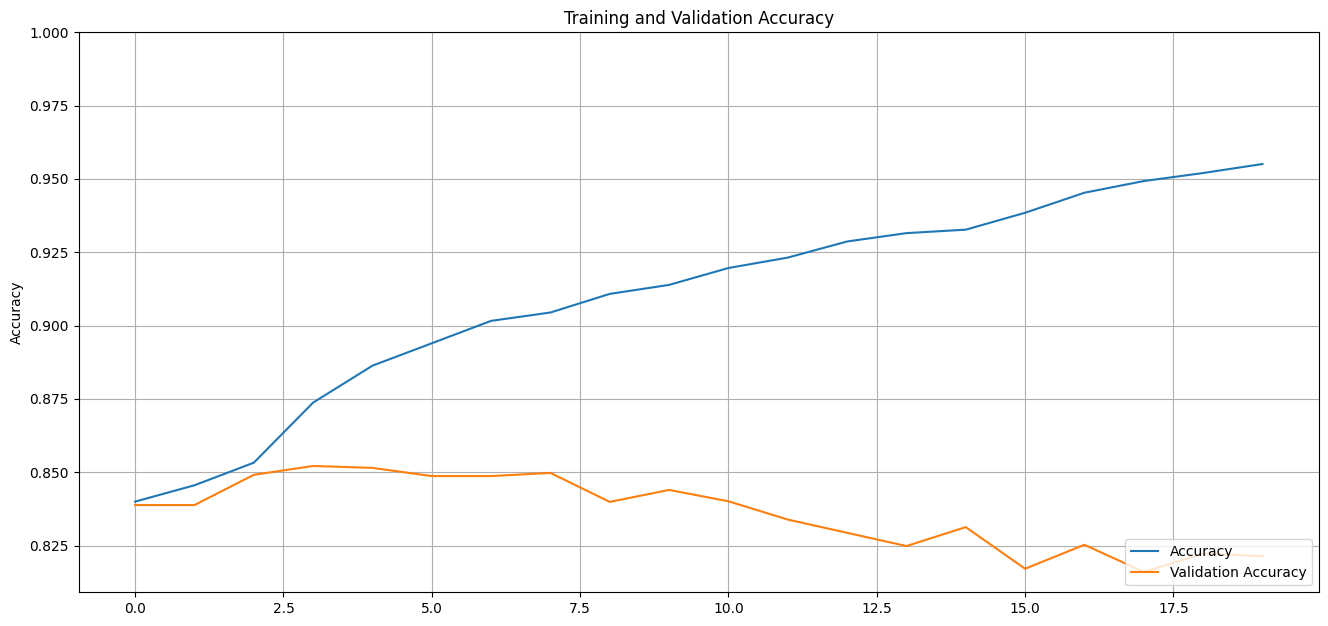

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.grid(visible=True)
plt.title('Training and Validation Accuracy')

In [ ]:
#MLP preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization, Dropout

import math
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
from tqdm.notebook import tqdm
tqdm.pandas() # để hiện progress bar

def lemmatize(sentence):
  doc = nlp(sentence)
  lemma_words = [token.lemma_ for token in doc]
  lemma_text = " ".join(lemma_words)
  return lemma_text

# progress_apply thay vì apply để hiện progress bar
# .values để chuyển thành numpy array
x = pd.Series(x)
x_mlp = x.progress_apply(lemmatize).values
tfidf = TfidfVectorizer(stop_words="english")
tfidf.fit(x_mlp)

# ta dùng kiểu csr matrix để tiết kiệm bộ nhớ
x_csr = tfidf.transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_csr, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
x_train_dense = x_train.toarray()
x_test_dense = x_test.toarray()
#MLP
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights = True)
def lr_exp_decay(epoch):
    k = 0.1
    # initial_lr == global variable
    if epoch > 8:
      return initial_lr * math.exp(-k*epoch)
    else:
      return initial_lr

initial_lr = 0.1
lr_scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

mlp = Sequential()
mlp.add(Input(shape=(list(x_csr.shape)[1],)))
mlp.add(Dense(64, activation="relu", kernel_initializer="he_normal"))
mlp.add(Dropout(0.2))
mlp.add(BatchNormalization())
mlp.add(Dense(128, activation="relu", kernel_initializer="he_normal"))
mlp.add(Dropout(0.2))
mlp.add(BatchNormalization())
mlp.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
mlp.add(Dropout(0.2))
mlp.add(BatchNormalization())
mlp.add(Dense(11, activation="sigmoid"))

# train
mlp.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=METRICS),
x_train_dense = x_train_dense.astype('float32')
x_test_dense = x_test_dense.astype('float32')

x_train_dense = np.nan_to_num(x_train_dense)
x_test_dense = np.nan_to_num(x_test_dense)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

history = mlp.fit(
    x_train_dense,
    y_train,
    validation_data=(x_test_dense, y_test),
    epochs=100
)

  0%|          | 0/2113 [00:00<?, ?it/s]

Epoch 1/100
53/53 [==============================] - 6s 65ms/step - loss: 0.7732 - accuracy: 0.6053 - precision: 0.2471 - recall: 0.5014 - val_loss: 0.5797 - val_accuracy: 0.8388 - val_precision: 0.7116 - val_recall: 0.3240
Epoch 2/100
53/53 [==============================] - 2s 43ms/step - loss: 0.5801 - accuracy: 0.7009 - precision: 0.3294 - recall: 0.5264 - val_loss: 0.4566 - val_accuracy: 0.8388 - val_precision: 0.7116 - val_recall: 0.3240
Epoch 3/100
53/53 [==============================] - 3s 59ms/step - loss: 0.4254 - accuracy: 0.8245 - precision: 0.5484 - recall: 0.5295 - val_loss: 0.4047 - val_accuracy: 0.8388 - val_precision: 0.7116 - val_recall: 0.3240
Epoch 4/100
53/53 [==============================] - 3s 60ms/step - loss: 0.3455 - accuracy: 0.8630 - precision: 0.6942 - recall: 0.5225 - val_loss: 0.4095 - val_accuracy: 0.8388 - val_precision: 0.7116 - val_recall: 0.3240
Epoch 5/100
53/53 [==============================] - 2s 42ms/step - loss: 0.3053 - accuracy: 0.8806 - pr

Text(0.5, 1.0, 'Training and Validation Accuracy')

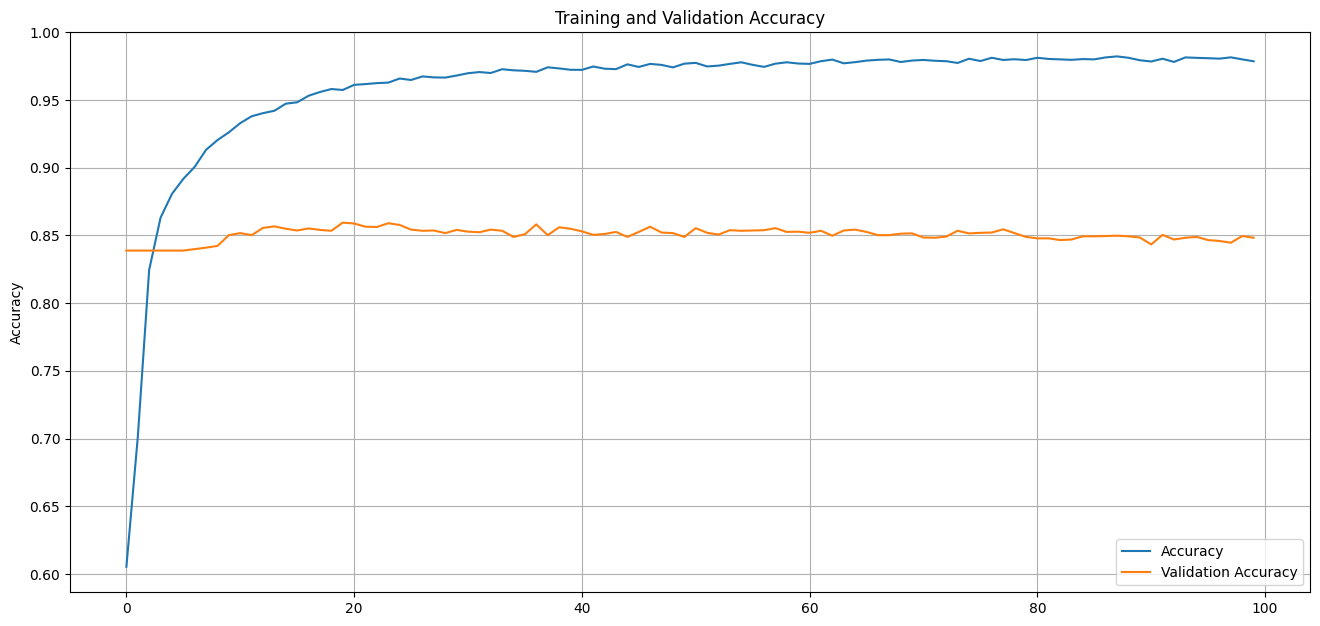

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.grid(visible=True)
plt.title('Training and Validation Accuracy')

Epoch 1/20
53/53 [==============================] - 50s 871ms/step - loss: 0.0064 - accuracy: 0.9670 - precision: 0.9314 - recall: 0.8964 - val_loss: 0.8874 - val_accuracy: 0.8953 - val_precision: 0.7708 - val_recall: 0.6771
Epoch 2/20
53/53 [==============================] - 55s 1s/step - loss: 0.0055 - accuracy: 0.9972 - precision: 0.9911 - recall: 0.9944 - val_loss: 0.8897 - val_accuracy: 0.8951 - val_precision: 0.7753 - val_recall: 0.6685
Epoch 3/20
53/53 [==============================] - 17s 328ms/step - loss: 0.0059 - accuracy: 0.9971 - precision: 0.9936 - recall: 0.9914 - val_loss: 0.8931 - val_accuracy: 0.8947 - val_precision: 0.7733 - val_recall: 0.6685
Epoch 4/20
53/53 [==============================] - 8s 161ms/step - loss: 0.0069 - accuracy: 0.9962 - precision: 0.9903 - recall: 0.9900 - val_loss: 0.8922 - val_accuracy: 0.8951 - val_precision: 0.7746 - val_recall: 0.6695
Epoch 5/20
53/53 [==============================] - 8s 161ms/step - loss: 0.0047 - accuracy: 0.9977 - pr

Text(0.5, 1.0, 'Training and Validation Accuracy')

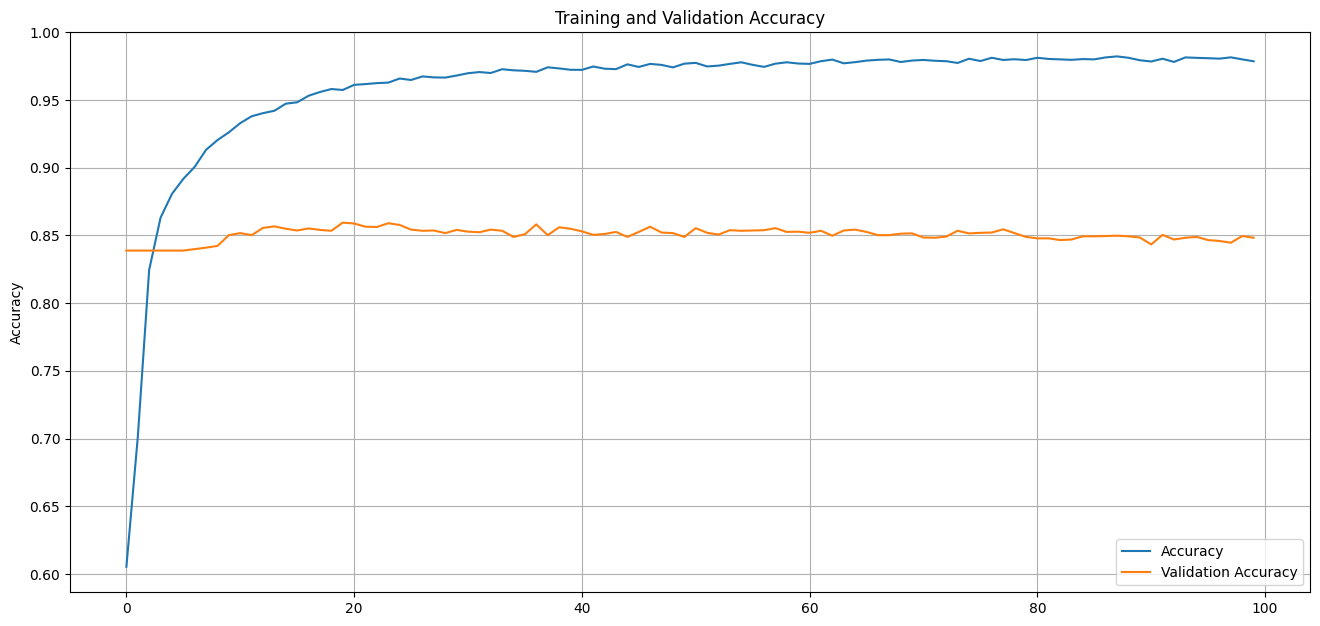

In [ ]:
fitting_model(df)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.grid(visible=True)
plt.title('Training and Validation Accuracy')

In [ ]:
#Create model
lstm = Sequential()
lstm.add(Input(shape=(1,), dtype=string))
# tokenizer
lstm.add(tokenizer)
# embedding
lstm.add(embedding_layer)
# RNN & MLP
lstm.add(Bidirectional(LSTM(64,
                                  dropout=0.2,
                                  recurrent_dropout=0.2,
                                  return_sequences=True)))
lstm.add(Bidirectional(LSTM(128,
                             dropout=0.2,
                             recurrent_dropout=0.2)))

lstm.add(Dense(11, activation="sigmoid"))

mlp = Sequential()
mlp.add(Input(shape=(list(x_csr.shape)[1],)))
mlp.add(Dense(64, activation="relu", kernel_initializer="he_normal"))
mlp.add(Dropout(0.2))
mlp.add(BatchNormalization())
mlp.add(Dense(128, activation="relu", kernel_initializer="he_normal"))
mlp.add(Dropout(0.2))
mlp.add(BatchNormalization())
mlp.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
mlp.add(Dropout(0.2))
mlp.add(BatchNormalization())
mlp.add(Dense(11, activation="sigmoid"))


In [ ]:
bert = model.to_json()
with open('bert+fine-tuning_architecture.json', 'w') as json_file:
    json_file.write(bert)

mlp_model = mlp.to_json()
with open('mlp_architecture.json', 'w') as json_file:
    json_file.write(mlp_model)

lstm_model = lstm.to_json()
with open('lstm_architecture.json', 'w') as json_file:
    json_file.write(lstm_model)